# FAIKR module 3 project

### Lorenzo Venieri , Luca Zucchini

## Introduction

Diabetes is a serious disease affecting millions of people across the entire world. Thus, correct and timely prediction of this disease is very important due to the complications it can have in the case of other life-threatening diseases.

Objective of this project is to apply the studied notions about Bayesian Networks to implement a probabilistic model on a dataset built from patients with diabetes.

## Dataset

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females
at least 21 years old of Pima Indian heritage.  
The Pima (or Akimel O'odham, also spelled Akimel Oʼotham, "River People," formerly known as Pima) are a group of Native Americans living in an area consisting of what is now central and southern Arizona, as well as northwestern Mexico in the states of Sonora and Chihuahua.
The diversion of the water and the introduction of non-native diet is said to have been the leading contributing factor in the high rate of diabetes among the Akimel Oʼodham tribe. They have the highest prevalence of type 2 diabetes in the world, much more than is observed in other U.S. populations.    
The general increased diabetes prevalence among Native Americans has been hypothesized as the result of the interaction of genetic predisposition (the thrifty phenotype or thrifty genotype), as suggested by anthropologist Robert Ferrell in 1984[13] and a sudden shift in diet during the last century from traditional agricultural crops to processed foods, together with a decline in physical activity.  
Between U.S. Pima indians, 34.2% of men and 40.8% of women suffer from diabetes as reported in https://doi.org/10.2337/dc06-0138.

From the dataset in the .csv file we can find several variables, some of them are independent
(several medical predictor variables) and only one target dependent variable (Outcome). It must be emphasized that the dataset makes no distinction between type 1 Diabetes and type 2 Diabetes, during the analysis we tackle this by splitting the '1' values in the Outcome column into two different columns representing, respectively, type 1 and type 2 Diabetes.

We have 9 different attributes:
1. Pregnancies: number of pregnancies
2. Glucose: plasma glucose concentrarion 
3. BloodPressure: diastolic blood pressure mm/Hg
4. SkinThickness: triceps skin fold thickness (mm)
5. Insulin: insulin in U/mL
6. BMI: Body mass index (weight in kg/(height in m)^2)
7. Diabetes Pedigree Function: scores likelihood of diabetes based on family history
8. Age: age of the person (years)
9. Outcome: patient has diabetes (0 = No, 1 = Yes)

The dataset contains info about 768 patients.

In [85]:
%pip install pgmpy


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_raw = pd.read_csv("data/diabetes.csv")
df_raw.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Exploratory Data Analysis

In [87]:
#Diabetes distribution in the dataset

df_raw['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In the dataset there are 268 patients with diabetes and 500 without. The Outcome column is imbalanced: only about 35% of the entries have diabetes. We will check, after the cleaning of the dataset, if this will still be the case.

/var/folders/fs/gjf_cxjd6t96c48h_6fgwmd40000gn/T/ipykernel_29923/2705674253.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_raw['Pregnancies'],rug=True,ax=axs[0])
/var/folders/fs/gjf_cxjd6t96c48h_6fgwmd40000gn/T/ipykernel_29923/2705674253.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplo

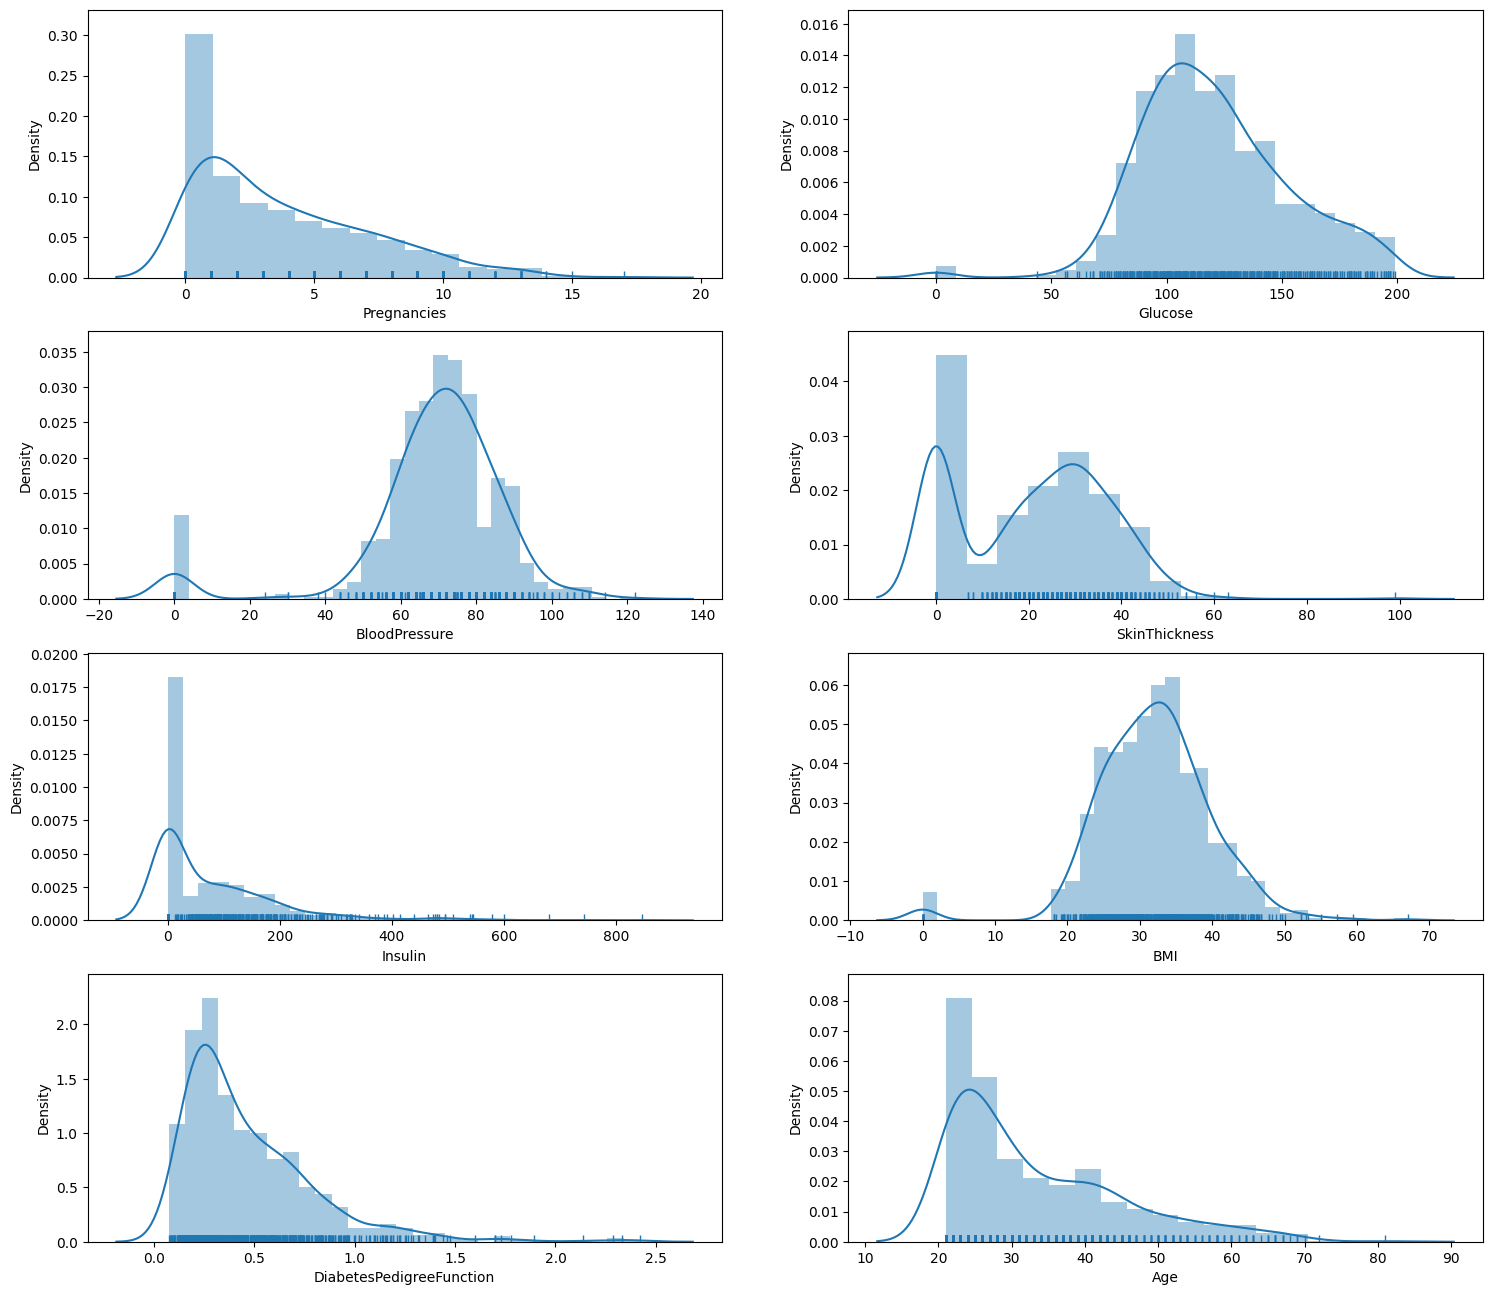

In [88]:
#Visualization of the other 8 (continuous) features

fig, axs = plt.subplots(4, 2, figsize=(18,16))
axs = axs.flatten()
sns.distplot(df_raw['Pregnancies'],rug=True,ax=axs[0])
sns.distplot(df_raw['Glucose'],rug=True,ax=axs[1])
sns.distplot(df_raw['BloodPressure'],rug=True,ax=axs[2])
sns.distplot(df_raw['SkinThickness'],rug=True,ax=axs[3])
sns.distplot(df_raw['Insulin'],rug=True,ax=axs[4])
sns.distplot(df_raw['BMI'],rug=True,ax=axs[5])
sns.distplot(df_raw['DiabetesPedigreeFunction'],rug=True,ax=axs[6])
sns.distplot(df_raw['Age'],rug=True,ax=axs[7])
plt.show()

The dataset has the column representing the presence of diabetes in the patient named as "Outcome" and in the description of the dataset there is no indication whether it takes in consideration type 1 Diabetes, type 2 Diabetes or both of them. To resolve this ambiguity we check if there are positives outcomes in rows with very low values of "Insulin": clear indication of type 1 Diabetes presence.


In [92]:
count = 0
for i in range(df_raw.shape[0]):
    if df_raw["Insulin"][i] < 1 and df_raw["Outcome"][i] == 1 :
        count += 1
print("In the dataset there are",count,"patients with type 1 diabetes among the total",df_raw["Outcome"].value_counts()[1],"patients with diabetes")

In the dataset there are 138 patients with type 1 diabetes among the total 268 patients with diabetes


We will deal with this "ambiguity" later on during the cleaning and preparation of the dataset.

### Data cleaning and preparation

In this chapter we take care of cleaning up the dataset. In particular, we ensure that the data can be used in a proper way by the model that we will use to perform our analysis.  
We will look for missing/null values and we will transform the data in order to model a bayesian network and to work with it, therefore we need to create columns populated by bins starting from columns of continuous values.

In [90]:
df_raw.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [91]:
for item in df_raw.columns :
    if item != "Outcome":
        print("In the column", item,"there are",(df_raw[item].values == 0).sum(),"null values")

In the column Pregnancies there are 111 null values
In the column Glucose there are 5 null values
In the column BloodPressure there are 35 null values
In the column SkinThickness there are 227 null values
In the column Insulin there are 374 null values
In the column BMI there are 11 null values
In the column DiabetesPedigreeFunction there are 0 null values
In the column Age there are 0 null values


In the dataset there are many null values appearing in the form of '0' rather than NaN. We need to underline that the assumption that a value '0' is a NaN value is obviously not general but it holds in this case since almost all of the columns cannot have a '0' value since it would make no sense (it is impossible to register a value of Glucose in the blood equal to 0).

 We decided to remove them instead of using statistical methods to predict the missing values, since we have few data and we want them to be as much predictive as possible. By the way, we have to consider that null values of Insulin are interesting as stated before.  

 We proceed with the removal of rows that have a null value in the columns: 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI'.  
Previous analysis showed that DiabetesPedigreeFunction column and Age column don't contain any null values.

In [93]:
df_clean = df_raw.copy(deep=True)

In [94]:
columns_to_clean = ['Glucose', 'BloodPressure', 'SkinThickness','BMI'] 
#A null value in these columns is surely an error since it's impossible to have value zero for these fetures
for item in columns_to_clean:
    drop_list = []
    for i in range(len(df_clean[item])):
        if df_clean[item][i] == 0 :
            drop_list.append(i)
    print("Column",item,"has been cleaned")
    df_clean.drop(labels= drop_list, axis= 0, inplace= True)
    df_clean.reset_index(drop=True, inplace=True)
    

Column Glucose has been cleaned
Column BloodPressure has been cleaned
Column SkinThickness has been cleaned
Column BMI has been cleaned


With regard to the Insulin column we consider the fact that a null value of insulin in the blood is a sure sign of the presence of type 1 Diabetes, so we proceed with removing all the rows that have a null value of both Insuline and Outcome, since it's impossible to have no insulin without having diabetes. (source: https://medlineplus.gov/lab-tests/insulin-in-blood/)

In [95]:
for i in range(len(df_clean["Insulin"])):
    if df_clean["Insulin"][i] == 0 and df_clean["Outcome"][i] == 0:
        df_clean.drop(labels= i, axis= 0, inplace= True)
print("Column 'Insulin' has been cleaned")
df_clean.reset_index(drop=True, inplace=True)

Column 'Insulin' has been cleaned


Another important step in the artificial intelligence field is to check whether the dataset is balanced with regard to the Target column, in this case the Outcome column. This is very important when dealing, for example, with neural networks or with common machine learning techniques, but in the case of probabilistic models, in this case bayesian network, the relation between imbalance of dataset and poor results is not trivial. There have been works that test the capability of some bayesian networks to work well also in the case of unbalanced dataset, but on the other hand researchers were not able to state that in general baesyan network are not influenced by imbalancing of dataset. (source : https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjL7ZrBz8b7AhXKg_0HHQFuDP8QFnoECAoQAQ&url=https%3A%2F%2Fwww.scitepress.org%2Fpapers%2F2015%2F52011%2F52011.pdf&usg=AOvVaw0erSA4Ha2SYrw13LgLnJ-j)  
  
  
For such reason, we check now if the dataset is balanced with respect to the Diabetes column.

In [97]:
print("There are",(df_clean["Outcome"].values == 1).sum(),"patients with diabetes")
print("There are",(df_clean["Outcome"].values == 0).sum(),"patients without diabetes")

There are 177 patients with diabetes
There are 262 patients without diabetes


The number of patients that suffer from diabetes is about 40% of the total population sample analyzed. This respects the data we have available regarding the incidence of diabetes in women belonging to the Pima tribe in the United States.  
For this reason we don't need to balance the dataset: it already represents the incidence of diabetes in the population under analysis.

Now we deal with splitting the Outcome column between type 1 and type 2 diabetes to better encode the relationships between risk factors and effects of diabetes into the network. To do so, we build two columns from our Outcome column: Diabetes_1 and Diabetes_2, respectively for patients with very low levels of insulin and positive Outcome, and for patients with diabetes but not low levels of insulin.

In [98]:
df_clean["Diabetes_1"] = np.zeros(df_clean.shape[0])

for i in range(df_clean.shape[0]):
    if df_clean["Insulin"][i] <= 5 and df_clean["Outcome"][i] == 1:
        df_clean["Outcome"][i] = 0
        df_clean["Diabetes_1"][i] = 1

df_clean['Diabetes_1'] = df_clean['Diabetes_1'].apply(np.int64)
df_clean.rename(columns={"Outcome": "Diabetes_2"},inplace=True)

/var/folders/fs/gjf_cxjd6t96c48h_6fgwmd40000gn/T/ipykernel_29923/4281590103.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Outcome"][i] = 0
/var/folders/fs/gjf_cxjd6t96c48h_6fgwmd40000gn/T/ipykernel_29923/4281590103.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Diabetes_1"][i] = 1


In [101]:
df_clean.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Diabetes_2,Diabetes_1
0,6,148,72,35,0,33.6,0.627,50,0,1
1,1,89,66,23,94,28.1,0.167,21,0,0
2,0,137,40,35,168,43.1,2.288,33,1,0
3,3,78,50,32,88,31.0,0.248,26,1,0
4,2,197,70,45,543,30.5,0.158,53,1,0


In [102]:
num_diab_1 = (df_clean["Diabetes_1"] == 1).sum()
num_diab_2 = (df_clean["Diabetes_2"] == 1).sum()
num_diab = num_diab_1 + num_diab_2

print('Number of patients with type 1 diabetes: ', num_diab_1)
print('Number of patients with type 2 diabetes: ', num_diab_2)
print('Total number of patients with diabetes: ', num_diab)
print('Number of patients without diabetes: ', df_clean.shape[0] - num_diab)

Number of patients with type 1 diabetes:  47
Number of patients with type 2 diabetes:  130
Total number of patients with diabetes:  177
Number of patients without diabetes:  262


### Binning
The final step regarding the dataset cleaning and preparation is to discretize our continuous features, transforming each column of the dataset into columns of bins so that we will be able to use them to perform parameter learning on our network using pgmpy.

The binning was made trying to group values ​​into ranges of interest, rather than simply splitting them into 'n' number of bins.  

In [103]:
df_bin = df_clean.copy(deep=True)

In [165]:
#configuration dictionary for binning

conf = {"Pregnancies" :{
            "bins" : [-1,3,6,9,18],
            "labels": ["0-3","3-6","6-9","9+"]},

        "Glucose" :{
            "bins" : [50,100,140,np.max(df_clean["Glucose"])],
            "labels" : ["50-100","100-140","140-200"]}, #low, medium and high levels of glucose

        "BloodPressure" :{
            "bins" : [20,60,80,110],
            "labels" : ["20-60","60-80","80-110"]}, #low, medium and high levels of blood pressure

        "SkinThickness" :{
            "bins" : [6,15,30,40,np.max(df_clean["SkinThickness"])],
            "labels" : ["7-15","15-30","30-40","40+"]},

        "Insulin" : {
            "bins" : [-1,5,50,120,150,np.max(df_clean["Insulin"])],
            "labels" : ["0-5","5-50","50-120","120-150","150+"]},
            
        "BMI" :{
            "bins" : [18,25,30,np.max(df_clean["BMI"])],
            "labels" : ["18-25","25-30","30+"]},

        "DiabetesPedigreeFunction" :{
            "bins" : [-1,0.2,0.3,0.5,0.7,0.9,np.max(df_clean["DiabetesPedigreeFunction"])],
            "labels" : ["0-0.2","0.2-0.3","0.3-0.5","0.5-0.7","0.7-0.9","0.9+"]},
            
        "Age" :{
            "bins" : [20,30,40,50,60,np.max(df_clean["Age"])],
            "labels" : ["20-30","30-40","40-50","50-60","60+"]}
        }       


In [166]:
for item in conf.keys():
    df_bin[item] = pd.cut(x=df_clean[item], bins=conf[item]["bins"],
                        labels=conf[item]["labels"])

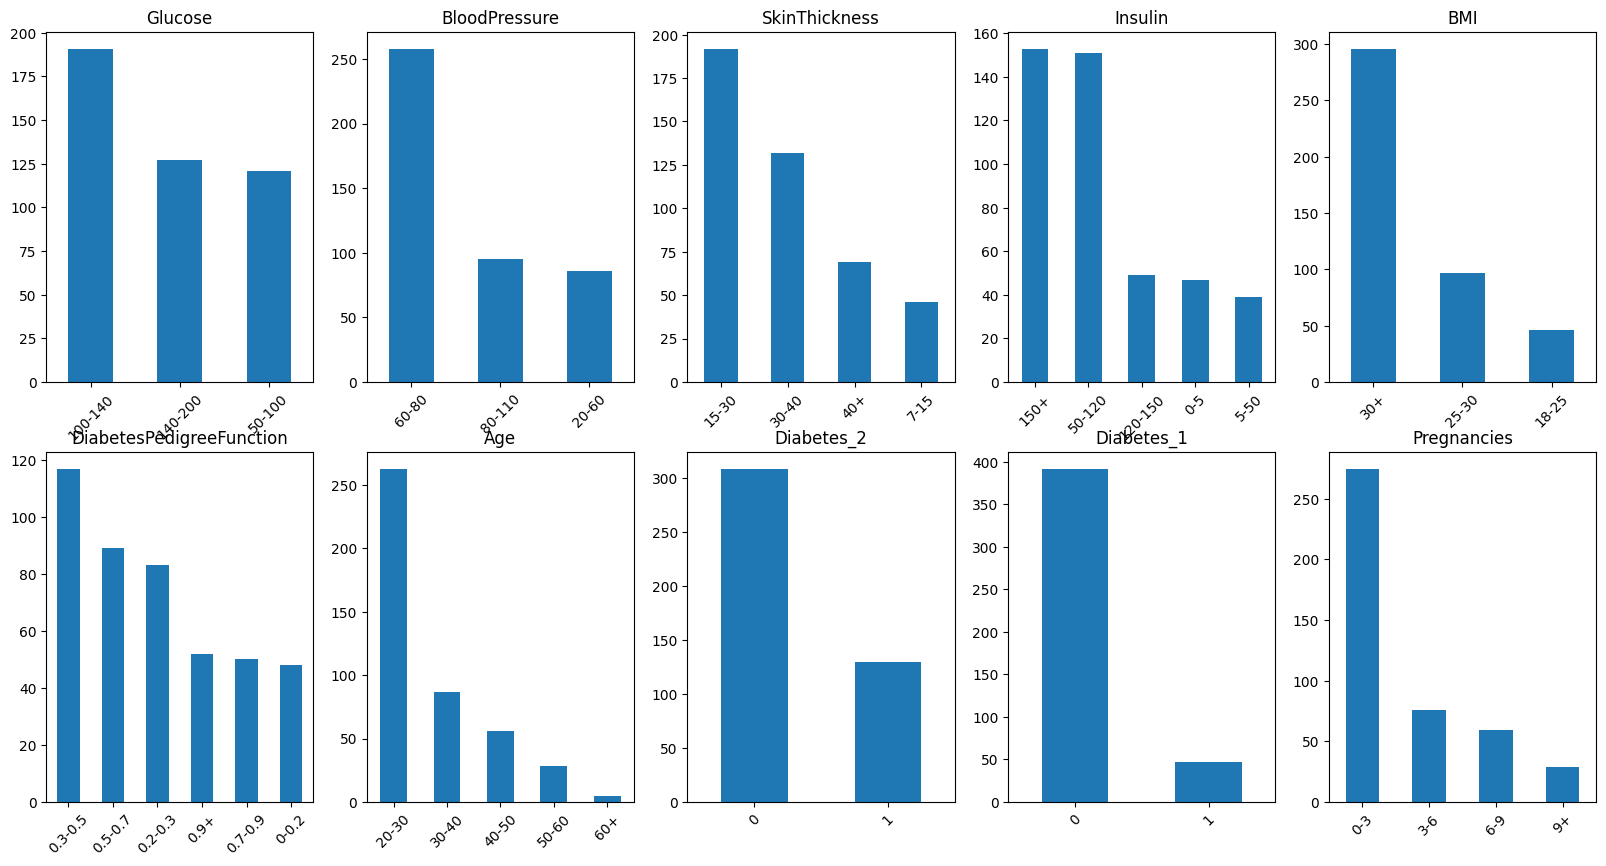

In [167]:
#Visualization of the binned features distributions

fig, axs = plt.subplots(2, 5, figsize=(20,10))
axs = axs.flatten()
for n,column_name in enumerate(df_bin.columns):
    df_bin[column_name].value_counts().plot(kind='bar', title = column_name, ax = axs[n-1], rot = 45)


Now that bins have been correctly created, we move to designing the network

# Network


In this chapter we will build the network by analyzing both correlations between the columns of our dataframe and scientific literature (internal medicine knowledge) related to the topic. We will then explore a variety of methods related to the analysis of Bayesian Networks.  
Connections between nodes have been implemented from scratch referring to a variety of scientific medical sources. 
In the medical field causal links are particularly challenging to model (often a huge variety of features are interlaced, causing directly or indirectly effects on each others), in this work only links that have been considered particularly relevant were defined.

The connections defined will be explained below.

Analyzing the correlations between columns of the dataframe can help us reasoning about the causal relationships between them. 

<AxesSubplot: >

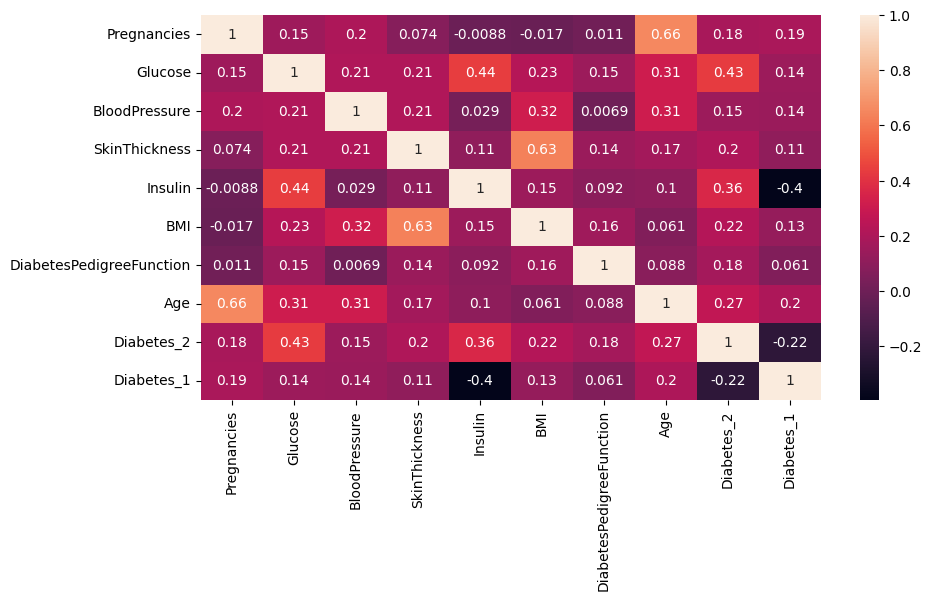

In [169]:
corr = df_clean.corr()
plt.figure(figsize=(10,5))
sns.heatmap(corr, annot=True)

Let's analyze the most interesting correlations we found with the correlation matrix, we'll use these considerations to build the structure of our Bayesian Network.

- **Age - Pregnancies** : As age increases it's more likely to have had more pregnancies.
- **Diabetes_2 - Glucose** : Suffering from diabetes makes it difficult to manage blood glucose levels. The same should apply for **Diabetes_1** but we don't have such a strong correlation, we will nonetheless put this causal link in our network.
- **Glucose - Insulin**: In normal conditions glucose and insulin levels are positively correlated because our body produces insulin in response to rising levels of glucose to absorb it.  
- **BMI - BloodPressure** : It's well established in medicine literature that being overweight causes hypertension. (https://www.ahajournals.org/doi/10.1161/circresaha.116.305697)
- **Insulin - SkinThickness** : SkinThickness is a measure of how much fat is stored in skin cells. We know that insulin promotes the storage of sugars triggering the metabolic process called lipogenesis. This process is how our body converts fatty acids and glycerol into fats. This is why high levels of insulin correlate with higher SkinThickness. (https://www.sciencedirect.com/topics/agricultural-and-biological-sciences/lipogenesis#:~:text=Insulin%20promotes%20lipogenesis%2C%20thereby%20resulting,Fig.)
- **BMI - SkinThickness** : Of course being overweight increses the chance of having more fat in the skin and vice versa.
- **Insulin - Diabetes_1** : Having type 1 diabetes means having problems producing insulin. This high negative correlation was expected since we built the Diabetes_1 column filtering for Diabetes cases with low insulin level.
- **Insulin - Diabetes_2** The same applies for Diabetes_2: it was expected to have high correlation since we selected only the cases of diabetes with not-low insulin level to build the Diabetes_2 column. Moreover, if a patient suffers from type 2 diabetes, her body still breaks down carbohydrate from her food and turns it into glucose. The pancreas then responds to this by releasing insulin. But because this insulin can't work properly, her blood sugar levels keep rising. This means more insulin is released.

### Showing the network

We show a graphical preliminary overview of the network using the visual library daft of pgmpy.  
The acronyms related to dataset attributes are the followings:




In [ ]:
%pip install daft

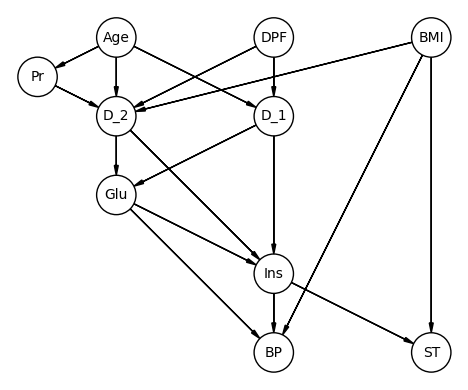

In [171]:
import daft
import matplotlib.pyplot as plt
from daft import PGM

pgm = PGM()

pgm.add_node(daft.Node('Age', "Age", 2, 5))
pgm.add_node(daft.Node('DPF', "DPF", 4, 5))
pgm.add_node(daft.Node('BMI', "BMI", 6, 5))

pgm.add_node(daft.Node('Pr', "Pr", 1, 4.5))

pgm.add_node(daft.Node('Diab_2', "D_2", 2, 4))
pgm.add_node(daft.Node('Diab_1', "D_1", 4, 4))

pgm.add_node(daft.Node('Glu', "Glu", 2, 3))

pgm.add_node(daft.Node('Ins', "Ins", 4, 2))

pgm.add_node(daft.Node('BP', "BP", 4, 1))
pgm.add_node(daft.Node('ST', "ST", 6, 1))

pgm.add_edge('Age', 'Pr')
pgm.add_edge('Pr', 'Diab_2')
pgm.add_edge('DPF', 'Diab_2')
pgm.add_edge('DPF', 'Diab_1')
pgm.add_edge('Age', 'Diab_2')
pgm.add_edge('Age', 'Diab_1')
pgm.add_edge('BMI','Diab_2')
pgm.add_edge('BMI','ST')
pgm.add_edge('BMI', 'BP')
pgm.add_edge('Diab_2', 'Glu')
pgm.add_edge('Diab_2', 'Ins')
pgm.add_edge('Diab_1', 'Glu')
pgm.add_edge('Diab_1', 'Ins')
pgm.add_edge('Glu', 'BP')
pgm.add_edge('Glu','Ins')
pgm.add_edge('Ins', 'BP')
pgm.add_edge('Ins','ST')

pgm.render()
plt.show()

We already explained the reason behind some of the edges of the network when we analyzed the correlation matrix, now we will discuss about the other edges we put in the network:

- **Insulin - BloodPressure**: Insulin can increase blood pressure via several mechanisms: increased renal sodium reabsorption, activation of the sympathetic nervous system, alteration of transmembrane ion transport, and hypertrophy of resistance vessels. https://pubmed.ncbi.nlm.nih.gov/7512468/#:~:text=Insulin%20can%20increase%20blood%20pressure,and%20hypertrophy%20of%20resistance%20vessels.

- **Age - Diabetes_1** and **Age - Diabetes_2**: The risk of developing diabetes increases with age. This risk is present for both types of diabetes with different weight: aging has the effect of increasing insulin resistance and lower the function of insulin-producing cells in pancreas.

- **Pregnancies - Diabetes_2**: Gestational Diabetes  
This is a type of diabetes that is first seen in a pregnant woman who did not have diabetes before she was pregnant. For most women with gestational diabetes, the diabetes goes away soon after delivery. When it does not go away, the diabetes is called type 2 diabetes. Even if the diabetes does go away after the baby is born, half of all women who had gestational diabetes develop type 2 diabetes later. https://www.cdc.gov/diabetes/basics/gestational.html

- **DiabetesPedigreeFunction - Diabetes_1** and **DiabetesPedigreeFunction - Diabetes_2**: Both types of diabetes have a genetic predisposition risk factor. The Diabetes Pedigree Function is an index that takes the family history of the patient into account to predict the likelihood of diabetes insurgence.

- **Glucose - BloodPressure** : Hyperglycemia can contribute to hypertension. High blood sugar can increase blood pressure through two primary means. First, untreated hyperglycemia can lead to nerve and blood vessel damage. Damage to the blood vessels causes the walls to stiffen, narrow, and accumulate plaque. Plaque buildup narrows the vessels, increasing pressure and contributing to hypertension. Second, chronic hyperglycemia leads to chronic hyperinsulinemia, that we have already seen causes hypertension. (https://www.endocrineweb.com/conditions/diabetes/can-blood-sugar-affect-blood-pressure)

## Creating the network

In [172]:
import pgmpy
from pgmpy.models import BayesianNetwork

model = BayesianNetwork(
    [('Age','Pregnancies'),('Pregnancies', 'Diabetes_2'),('DiabetesPedigreeFunction', 'Diabetes_1'),('DiabetesPedigreeFunction', 'Diabetes_2'),
    ('Age', 'Diabetes_1'), ('Age', 'Diabetes_2'),('BMI','Diabetes_2'), ('BMI','SkinThickness'),('BMI', 'BloodPressure'),
    ('Diabetes_1', 'Glucose'),('Diabetes_1', 'Insulin'), ('Diabetes_2', 'Glucose'),('Diabetes_2', 'Insulin'),
    ('Glucose', 'BloodPressure'),('Glucose', 'Insulin'),('Insulin','BloodPressure'),('Insulin','SkinThickness')])

### Analyzing the network

Follows a series of experiments done on the network by applying a variety of methods provided by the pgmpy library in order to see in practice all the concepts addressed during the course.

In [173]:
# Showing all the nodes of the model
model.nodes()

NodeView(('Age', 'Pregnancies', 'Diabetes_2', 'DiabetesPedigreeFunction', 'Diabetes_1', 'BMI', 'SkinThickness', 'BloodPressure', 'Glucose', 'Insulin'))

In [174]:
# Showing all the edges of the model
model.edges()

OutEdgeView([('Age', 'Pregnancies'), ('Age', 'Diabetes_1'), ('Age', 'Diabetes_2'), ('Pregnancies', 'Diabetes_2'), ('Diabetes_2', 'Glucose'), ('Diabetes_2', 'Insulin'), ('DiabetesPedigreeFunction', 'Diabetes_1'), ('DiabetesPedigreeFunction', 'Diabetes_2'), ('Diabetes_1', 'Glucose'), ('Diabetes_1', 'Insulin'), ('BMI', 'Diabetes_2'), ('BMI', 'SkinThickness'), ('BMI', 'BloodPressure'), ('Glucose', 'BloodPressure'), ('Glucose', 'Insulin'), ('Insulin', 'BloodPressure'), ('Insulin', 'SkinThickness')])

In [175]:
# Local independencies of a single node
model.local_independencies("Diabetes_1")

(Diabetes_1 ⟂ Pregnancies, BMI, Diabetes_2 | DiabetesPedigreeFunction, Age)

In [176]:
model.local_independencies("SkinThickness")

(SkinThickness ⟂ Diabetes_1, BloodPressure, Diabetes_2, DiabetesPedigreeFunction, Pregnancies, Glucose, Age | Insulin, BMI)

In [177]:
# Checking d-separation between variables with and without evidence
# Two sets of nodes X, Y are d-separated given Z if there is no active trail between any x ∈ X and y ∈ Y given Z

print(model.is_dconnected("BloodPressure", "SkinThickness"))
print(model.is_dconnected("BloodPressure", "SkinThickness",observed=["BMI"] ))
print(model.is_dconnected("BloodPressure", "SkinThickness",observed=["BMI", 'Insulin'] ))

True
True
False


In [178]:
# Function is_irrelevant recalls the definition of irrelevance given during the course 

def is_irrelevant(node1,node2,evidence):
  if ((node2 in (model.get_ancestral_graph(node1)and model.get_ancestral_graph(evidence))) and model.is_dconnected(node1, node2,observed=evidence )):
    print("Node", node1, "is not irrelevant with resepect to", node2, "given the evidence", evidence)
  else:
    print("Node", node1, "is irrelevant with resepect to", node2, "given the evidence", evidence)

is_irrelevant("Glucose", "Insuline", "Diabetes_1")

Node Glucose is irrelevant with resepect to Insuline given the evidence Diabetes_1


In [179]:
# Checking active trails from blood pressure given the evidence diabetes
model.active_trail_nodes('BloodPressure', observed='Diabetes_1')

{'BloodPressure': {'Age',
  'BMI',
  'BloodPressure',
  'DiabetesPedigreeFunction',
  'Diabetes_2',
  'Glucose',
  'Insulin',
  'Pregnancies',
  'SkinThickness'}}

In [180]:
# Checking the markov blanket of the node BloodPressure
model.get_markov_blanket("BloodPressure")

['Glucose', 'Insulin', 'BMI']

### Parameter learning

The task of parameter estimation consists of learning the CPTs of the bayesian network knowing its structure. We already built the the structure of our network from preliminary analysis of internal medicine knowledge, now we'll use our data to find the parameters of the network.

In pgmpy are available a variety of estimators and priors to use. We will use BayesianEstimator with Bayesian Dirichlet equivalent uniform prior (BDeu). 

In [181]:
from pgmpy.estimators import BayesianEstimator

df = df_bin

In [182]:
model.cpds = []
model.fit(data=df, estimator=BayesianEstimator, prior_type="BDeu")

for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')
model.cpds = []
model.fit(data=df, estimator=BayesianEstimator, prior_type="BDeu")

for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

CPT of Age:
+------------+-----------+
| Age(20-30) | 0.594595  |
+------------+-----------+
| Age(30-40) | 0.198198  |
+------------+-----------+
| Age(40-50) | 0.128378  |
+------------+-----------+
| Age(50-60) | 0.0653153 |
+------------+-----------+
| Age(60+)   | 0.0135135 |
+------------+-----------+ 

CPT of Pregnancies:
+------------------+-----+---------------------+
| Age              | ... | Age(60+)            |
+------------------+-----+---------------------+
| Pregnancies(0-3) | ... | 0.20833333333333334 |
+------------------+-----+---------------------+
| Pregnancies(3-6) | ... | 0.20833333333333334 |
+------------------+-----+---------------------+
| Pregnancies(6-9) | ... | 0.375               |
+------------------+-----+---------------------+
| Pregnancies(9+)  | ... | 0.20833333333333334 |
+------------------+-----+---------------------+ 

CPT of Diabetes_2:
+--------------------------+-----+--------------------------------+
| Age                      | ... | Age(60

In [183]:
# Checking the validity of the model 
# This method checks if the sum of the probabilities for each state is equal to 1 (tol=0.01) and if the CPDs associated with nodes are consistent with their parents.
model.check_model()

True

In [184]:
#Cardinality of all model nodes
model.get_cardinality()

defaultdict(int,
            {'Age': 5,
             'Pregnancies': 4,
             'Diabetes_2': 2,
             'DiabetesPedigreeFunction': 6,
             'Diabetes_1': 2,
             'BMI': 3,
             'SkinThickness': 4,
             'BloodPressure': 3,
             'Glucose': 3,
             'Insulin': 5})

## Inferences

Pgmpy allows to develop both exact and approximate inference on the Bayesian Network, in particular in this section both are presented exploring a variety of different methods related.

### Exact inference

Exact Inference in pgmpy is implemented through the Variable Elimination Method and Belief Propagation rather than with simple enumeration; being one of the purpouses of this work exploring topics seen in class, the former is choosen.


In [185]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)

Let's see some examples of reasoning patterns: 

- Causal (prediction): given evidence from one/some ancestral node/s find the probability distribution for a descendant node.

- Evidential (explanation): given evidence on a/some descendent node/s find the probability distribution for an ancestor node. 

- Intercausal (explaining away): given evidence of a/some descendant node/s and one (or some) of its ancestors find the probability distribution for another of its ancestors.

In [186]:
#Causal inference (prediction): probability that the patient has diabetes given her number of pregnancies

print('Prior probability distribution of type 2 diabetes:')
print(infer.query(["Diabetes_2"]))

print('Probability of having type 2 diabetes with 0 to 3 pregnancies:')
print(infer.query(["Diabetes_2"],evidence={"Pregnancies": '0-3'}))

print('Probability of having type 2 diabetes with more than 9 pregnancies:')
print(infer.query(["Diabetes_2"],evidence={"Pregnancies": '9+'}))

Prior probability distribution of type 2 diabetes:
+---------------+-------------------+
| Diabetes_2    |   phi(Diabetes_2) |
+===============+===================+
| Diabetes_2(0) |            0.6802 |
+---------------+-------------------+
| Diabetes_2(1) |            0.3198 |
+---------------+-------------------+
Probability of having type 2 diabetes with 0 to 3 pregnancies:
+---------------+-------------------+
| Diabetes_2    |   phi(Diabetes_2) |
+===============+===================+
| Diabetes_2(0) |            0.7295 |
+---------------+-------------------+
| Diabetes_2(1) |            0.2705 |
+---------------+-------------------+
Probability of having type 2 diabetes with more than 9 pregnancies:
+---------------+-------------------+
| Diabetes_2    |   phi(Diabetes_2) |
+===============+===================+
| Diabetes_2(0) |            0.4516 |
+---------------+-------------------+
| Diabetes_2(1) |            0.5484 |
+---------------+-------------------+


As expected, we can see that it is more likely to develop type 2 diabetes with a higher number of pregnancies.

In [187]:
print('Prior probability distribution of type 1 diabetes:')
print(infer.query(["Diabetes_1"]))

print('Probability of having type 1 diabetes with 0 to 3 pregnancies:')
print(infer.query(["Diabetes_1"],evidence={"Pregnancies": '0-3'}))

print('Probability of having type 1 diabetes with more than 9 pregnancies:')
print(infer.query(["Diabetes_1"],evidence={"Pregnancies": '9+'}))

Prior probability distribution of type 1 diabetes:
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.8859 |
+---------------+-------------------+
| Diabetes_1(1) |            0.1141 |
+---------------+-------------------+
Probability of having type 1 diabetes with 0 to 3 pregnancies:
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.9199 |
+---------------+-------------------+
| Diabetes_1(1) |            0.0801 |
+---------------+-------------------+
Probability of having type 1 diabetes with more than 9 pregnancies:
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.7871 |
+---------------+-------------------+
| Diabetes_1(1) |            0.2129 |
+---------------+-------------------+


We can see that even if the node Pregnancies does not directly influence the node Diabetes_1, its effect can be observed on the latter: the probability of having diabetes_1 increses with the number of Pregnancies. This may be explained by the influence of Age over both Pregnancies and Diabetes_1.

In [188]:
#Evidential inference (explanation): probability of having diabetes given that the patient has very low/high insulin level
print('Prior probability distribution of type 2 diabetes:')
print(infer.query(["Diabetes_2"]))

print('Probability of having type 2 diabetes given low insulin level:')
print(infer.query(["Diabetes_2"],evidence={"Insulin": '0-5'}))

print('Probability of having type 2 diabetes given high insulin level:')
print(infer.query(["Diabetes_2"],evidence={"Insulin": '150+'}))

Prior probability distribution of type 2 diabetes:
+---------------+-------------------+
| Diabetes_2    |   phi(Diabetes_2) |
+===============+===================+
| Diabetes_2(0) |            0.6802 |
+---------------+-------------------+
| Diabetes_2(1) |            0.3198 |
+---------------+-------------------+
Probability of having type 2 diabetes given low insulin level:
+---------------+-------------------+
| Diabetes_2    |   phi(Diabetes_2) |
+===============+===================+
| Diabetes_2(0) |            0.8860 |
+---------------+-------------------+
| Diabetes_2(1) |            0.1140 |
+---------------+-------------------+
Probability of having type 2 diabetes given high insulin level:
+---------------+-------------------+
| Diabetes_2    |   phi(Diabetes_2) |
+===============+===================+
| Diabetes_2(0) |            0.4946 |
+---------------+-------------------+
| Diabetes_2(1) |            0.5054 |
+---------------+-------------------+


In [189]:
print('Prior probability distribution of type 1 diabetes:')
print(infer.query(["Diabetes_1"]))

print('Probability of having type 1 diabetes given low insulin level:')
print(infer.query(["Diabetes_1"],evidence={"Insulin": '0-5'}))

print('Probability of having type 1 diabetes given high insulin level:')
print(infer.query(["Diabetes_1"],evidence={"Insulin": '150+'}))

Prior probability distribution of type 1 diabetes:
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.8859 |
+---------------+-------------------+
| Diabetes_1(1) |            0.1141 |
+---------------+-------------------+
Probability of having type 1 diabetes given low insulin level:
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.0139 |
+---------------+-------------------+
| Diabetes_1(1) |            0.9861 |
+---------------+-------------------+
Probability of having type 1 diabetes given high insulin level:
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.9744 |
+---------------+-------------------+
| Diabetes_1(1) |            0.0256 |
+---------------+-------------------+


Having a very low insulin level is almost a sure sign of having type 1 diabetes. This was expected as we built the Diabetes_1 column with this consideration in mind.

In [201]:
#Intercausal inference (explaining away):
# what's the probability that she has type 1 or 2 diabetes given that she has high blood pressure but she's not overweight?

print('Prior probability distribution of type 2 diabetes:')
print(infer.query(["Diabetes_2"]))

print('Probability of having type 2 diabetes given that she has high blood pressure:')
print(infer.query(["Diabetes_2"],evidence={"BloodPressure": '80-110'}))

print('Probability of having type 2 diabetes given that she has high blood pressure but she is not overweight:')
print(infer.query(["Diabetes_2"],evidence={"BloodPressure": '80-110', 'BMI': '18-25' }))

print('Probability of having type 2 diabetes given that she has high blood pressure and she is overweight:')
print(infer.query(["Diabetes_2"],evidence={"BloodPressure": '80-110', 'BMI': '30+' }))

Prior probability distribution of type 2 diabetes:
+---------------+-------------------+
| Diabetes_2    |   phi(Diabetes_2) |
+===============+===================+
| Diabetes_2(0) |            0.6802 |
+---------------+-------------------+
| Diabetes_2(1) |            0.3198 |
+---------------+-------------------+
Probability of having type 2 diabetes given that she has high blood pressure:
+---------------+-------------------+
| Diabetes_2    |   phi(Diabetes_2) |
+===============+===================+
| Diabetes_2(0) |            0.6407 |
+---------------+-------------------+
| Diabetes_2(1) |            0.3593 |
+---------------+-------------------+
Probability of having type 2 diabetes given that she has high blood pressure but she is not overweight:
+---------------+-------------------+
| Diabetes_2    |   phi(Diabetes_2) |
+===============+===================+
| Diabetes_2(0) |            0.6088 |
+---------------+-------------------+
| Diabetes_2(1) |            0.3912 |
+------

That evidence of the patient having high blood pressure increases the probability of her having type 2 diabetes. 

In [200]:
print('Prior probability distribution of type 1 diabetes:')
print(infer.query(["Diabetes_1"]))

print('Probability of having type 1 diabetes given that she has high blood pressure:')
print(infer.query(["Diabetes_1"],evidence={"BloodPressure": '80-110'}))

print('Probability of having type 1 diabetes given that she has high blood pressure but she is not overweight:')
print(infer.query(["Diabetes_1"],evidence={"BloodPressure": '80-110', 'BMI': '18-25' }))

print('Probability of having type 1 diabetes given that she has high blood pressure and she is overweight:')
print(infer.query(["Diabetes_1"],evidence={"BloodPressure": '80-110', 'BMI': '30+' }))

Prior probability distribution of type 1 diabetes:
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.8859 |
+---------------+-------------------+
| Diabetes_1(1) |            0.1141 |
+---------------+-------------------+
Probability of having type 1 diabetes given that she has high blood pressure:
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.8156 |
+---------------+-------------------+
| Diabetes_1(1) |            0.1844 |
+---------------+-------------------+
Probability of having type 1 diabetes given that she has high blood pressure but she is not overweight:
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.7708 |
+---------------+-------------------+
| Diabetes_1(1) |            0.2292 |
+------

#### MAP queries

Maximum a posteriori (MAP) queries find the most probable configuration (called MAP configuration) of some specific variables of interest (also called MAP variable), given observations of some evidence variables.
The result of MAP queries is (in case of discrete random variables) a single value rather than a probability which encodes the instantiation of the MAP variable with higher probability given the evidence.

In [ ]:
# let's see how the most likely insulin level changes as we change evidence

print(infer.map_query(["Insulin"]))
print(infer.map_query(["Insulin"], evidence={'Glucose': '70-100'}))
print(infer.map_query(["Insulin"], evidence={'Diabetes_2': 1}))
print(infer.map_query(["Insulin"], evidence={'Diabetes_1': 1}))

Eliminating: Age: 100%|██████████| 7/7 [00:00<00:00, 315.83it/s]            


{'Insulin': '50-120'}


Eliminating: Diabetes_2: 100%|██████████| 6/6 [00:00<00:00, 361.32it/s]     


{'Insulin': '50-120'}


Eliminating: Age: 100%|██████████| 6/6 [00:00<00:00, 226.38it/s]            


{'Insulin': '150+'}


Eliminating: Age: 100%|██████████| 6/6 [00:00<00:00, 365.12it/s]            

{'Insulin': '0-5'}


## Approximate Inference

In [ ]:
from pgmpy.inference import ApproxInference
from pgmpy.sampling import BayesianModelSampling

In [ ]:
infer = ApproxInference(model)
inference = BayesianModelSampling(model)

In [ ]:
# Sampling from an empty network
print(infer.query(variables=["Diabetes_2"], n_samples=100)) 

In [ ]:
# Showing the convergence increasing number of samples
print(infer.query(variables=["BloodPressure"], n_samples=10)) #approximate probability with a low number of samples

print(infer.query(variables=["BloodPressure"], n_samples=10000)) #approximate probability with an high number of samples

print(VariableElimination(model).query(["BloodPressure"]))      #true probability

We can observe that with a small number of samples we don't even find all the possible events for BloodPressure.

In [ ]:
print(infer.query(variables=["Diabetes_2"], n_samples=10)) #approximate probability with a low number of samples

print(infer.query(variables=["Diabetes_2"], n_samples=100)) #approximate probability with a medium number of samples

print(infer.query(variables=["Diabetes_2"], n_samples=10000)) #approximate probability with an high number of samples

print('True probability:')
print(VariableElimination(model).query(["Diabetes_2"]))      #true probability

In [ ]:
#Likelihood weighting
#let's see the results of a sampling process
print(inference.likelihood_weighted_sample(size=10)) #size: number of samples


In [ ]:
# We can observe the distribution obtained to derive the approx probabilities
print(infer.get_distribution(inference.likelihood_weighted_sample( size=1000), ["Diabetes_2"], joint=True))
print(infer.get_distribution(inference.likelihood_weighted_sample( size=1000), ["Diabetes_1"], joint=True))

In [ ]:
# Rejection sampling
print(infer.get_distribution(inference.rejection_sample( size=1000), ["Diabetes_2"]))
print(infer.get_distribution(inference.rejection_sample( size=1000), ["Diabetes_1"]))

We observe that, given the same number of samples, sampling from an empty network, likelihood weighting and rejection sampling give us different results. This was expected as we would need more samples to reach convergence for all theese three methods.

# Conclusions

Now that we have explored some functionalities of pgmpy to deal with our network we will explore our model to see if we can get some useful insights about diabetes and the related features from what the model has learned using the provided dataset.

In [ ]:
conf

In [ ]:
for i in conf["Glucose"]["labels"]:
    print("Probability of having type 1 Diabetes with a value of glucose between",i)
    print(infer.query(["Diabetes_1"],evidence={"Glucose": i}))
    print("Probability of having type 2 Diabetes with a value of glucose between",i)
    print(infer.query(["Diabetes_2"],evidence={"Glucose": i}))

In [ ]:
for i in conf["BloodPressure"]["labels"]:
    print("Probability of having type 1 Diabetes with a value of BloodPressure between",i)
    print(infer.query(["Diabetes_1"],evidence={"BloodPressure": i}))
    print("Probability of having type 2 Diabetes with a value of BloodPressure between",i)
    print(infer.query(["Diabetes_2"],evidence={"BloodPressure": i}))

In [ ]:
for i in conf["Pregnancies"]["labels"]:
    print("Probability of having type 1 Diabetes with a value of Pregnancies between",i)
    print(infer.query(["Diabetes_1"],evidence={"Pregnancies": i}))
    print("Probability of having type 2 Diabetes with a value of Pregnancies between",i)
    print(infer.query(["Diabetes_2"],evidence={"Pregnancies": i}))

In [ ]:
for i in conf["Insulin"]["labels"]:
    print("Probability of having type 1 Diabetes with a value of Insulin between",i)
    print(infer.query(["Diabetes_1"],evidence={"Insulin": i}))
    print("Probability of having type 2 Diabetes with a value of Insulin between",i)
    print(infer.query(["Diabetes_2"],evidence={"Insulin": i}))

In line with basic knowledge of internal medicine, we can state that the most indicative features ( among the avaible ones ) to detect the presence of Diabetes in patients are: Glucose, number of pregnancies and Insulin. Of course we have to consider that the number of pregnacies is relevant only while considering female patients, so we can assert that Glucose and Insulin are the most general and significative data to indicate the presence of Diabetes starting from a blood analysis.